# Kimberly Cui, Stats 140XP Project – Analysis 
### Measuring the Predictive Relationship Between Investor Sentiment and Next-Day Bitcoin Returns

#### Exploratory Data Analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("../data/fnp-btc_data.csv")
df.head()

,Date,sentiment,sentiment_label,Open,High,Low,Close,Volume
0,2018-02-01,30,Fear,10269.843887,10332.946065,8700.332595,9171.249369,4.557095e+09
1,2018-02-02,15,Extreme Fear,9118.231270,9127.685961,7588.546351,8768.328115,5.511338e+09
2,2018-02-03,40,Fear,8763.536968,9417.790992,8173.729947,9191.270888,4.856473e+09
3,2018-02-04,24,Extreme Fear,9198.067914,9351.571884,7986.357859,8256.583798,3.993494e+09
4,2018-02-05,11,Extreme Fear,8215.505812,8343.181452,6665.107706,6905.959543,4.795002e+09


In [10]:
df.shape

(2848, 8)

### Part 1: Construct returns + first time-series plots

In [11]:
# make sure columns are real! 
df.columns

# make sure dates are real! preparation for time series analysis 
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.head() 

,Date,sentiment,sentiment_label,Open,High,Low,Close,Volume
0,2018-02-01,30,Fear,10269.843887,10332.946065,8700.332595,9171.249369,4.557095e+09
1,2018-02-02,15,Extreme Fear,9118.231270,9127.685961,7588.546351,8768.328115,5.511338e+09
2,2018-02-03,40,Fear,8763.536968,9417.790992,8173.729947,9191.270888,4.856473e+09
3,2018-02-04,24,Extreme Fear,9198.067914,9351.571884,7986.357859,8256.583798,3.993494e+09
4,2018-02-05,11,Extreme Fear,8215.505812,8343.181452,6665.107706,6905.959543,4.795002e+09


In [12]:
# construct log returns (dependent variable) 
# For each day, compute how much the price changes (in log terms) from today to tomorrow. 

df["log_price"] = np.log(df["Close"])
df["return_t1"] = df["log_price"].shift(-1) - df["log_price"]
df = df.dropna()

df.head()

,Date,sentiment,sentiment_label,Open,High,Low,Close,Volume,log_price,return_t1
0,2018-02-01,30,Fear,10269.843887,10332.946065,8700.332595,9171.249369,4.557095e+09,9.123829,-0.044927
1,2018-02-02,15,Extreme Fear,9118.231270,9127.685961,7588.546351,8768.328115,5.511338e+09,9.078901,0.047108
2,2018-02-03,40,Fear,8763.536968,9417.790992,8173.729947,9191.270888,4.856473e+09,9.126009,-0.107243
3,2018-02-04,24,Extreme Fear,9198.067914,9351.571884,7986.357859,8256.583798,3.993494e+09,9.018766,-0.178626
4,2018-02-05,11,Extreme Fear,8215.505812,8343.181452,6665.107706,6905.959543,4.795002e+09,8.840140,0.117749


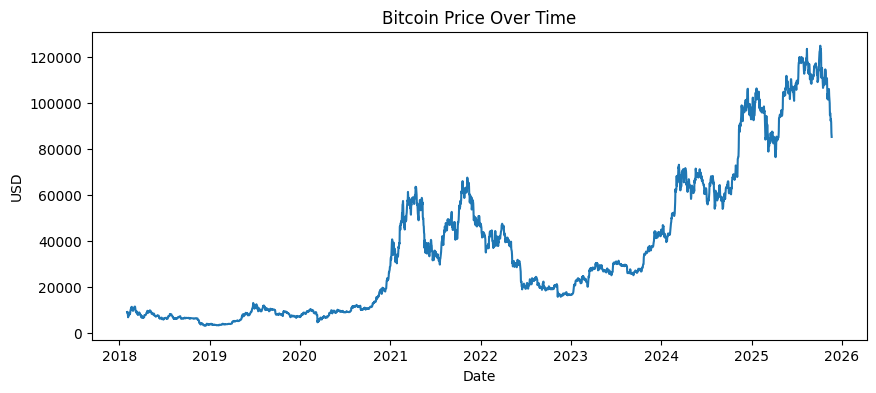

In [13]:
# plot bitcoin price over time 
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["Close"])
plt.title("Bitcoin Price Over Time")
plt.xlabel("Date")
plt.ylabel("USD")
plt.show()


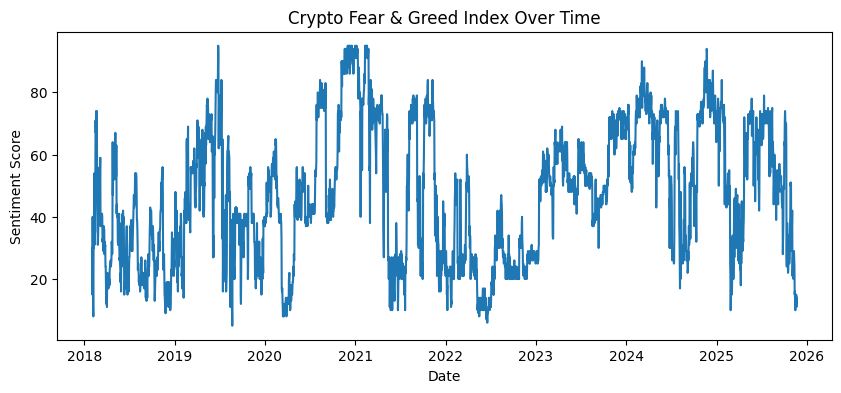

In [14]:
# plot sentiment over time 
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["sentiment"]) 
plt.title("Crypto Fear & Greed Index Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.show() 


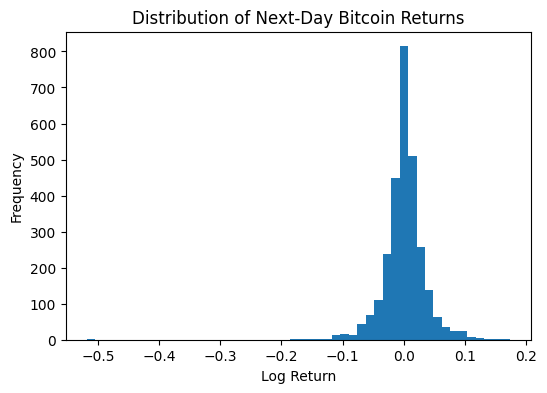

In [15]:
# Plot return distribution (fat tails preview)
plt.figure(figsize=(6,4))
plt.hist(df["return_t1"], bins=50)
plt.title("Distribution of Next-Day Bitcoin Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()


### Part 2: Baseline regression + diagnostics

In [16]:
# baseline ols model 
import statsmodels.api as sm

X = sm.add_constant(df["sentiment"])
y = df["return_t1"]

ols = sm.OLS(y, X).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:              return_t1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.366
Date:                Mon, 15 Dec 2025   Prob (F-statistic):             0.0368
Time:                        12:43:05   Log-Likelihood:                 5578.0
No. Observations:                2847   AIC:                        -1.115e+04
Df Residuals:                    2845   BIC:                        -1.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.396      0.1

Baseline OLS model with weaknesses 

Observations: 
* Low R^2: (0.2%)
* F-stat: significant sentiment coefficient 
* DW (durbin-watson) ≈ 2 --> little to no autocorrelation (suggesting limited first-order autocorrelation)
* Kurtosis = 24.199 & Jarque-Bera p-value = 0.000 --> returns are extremely fat-tailed and non-normal


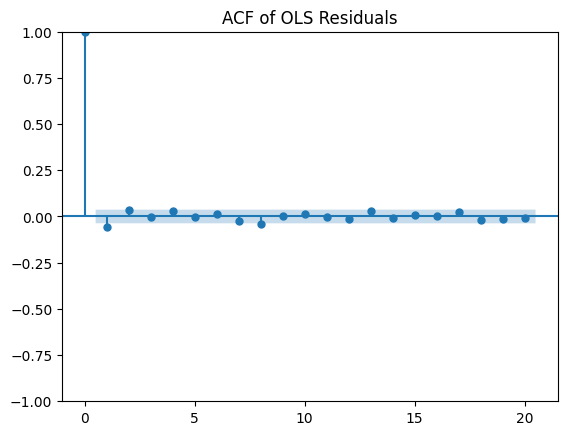

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ols.resid, lags=20)
plt.title("ACF of OLS Residuals")
plt.show()

# Bars outside the blue band --> autocorrelation


In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(ols.resid, X)
bp_test

# results: (LM stat, LM p-value, F stat, F p-value)


(5.6878339406491385,
 0.01708292790667937,
 5.695216370255471,
 0.017076212784629414)

p-val > 0.05 --> hetereoskedascity present 

In [19]:
# corrective action!!! --> use Newey–West (HAC) standard errors 

nw = ols.get_robustcov_results(cov_type="HAC", maxlags=5)
print(nw.summary())

# What changes: Standard errors, t-stats, p-values
# What stays: Coefficient estimates


                            OLS Regression Results                            
Dep. Variable:              return_t1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.503
Date:                Mon, 15 Dec 2025   Prob (F-statistic):             0.0613
Time:                        12:43:05   Log-Likelihood:                 5578.0
No. Observations:                2847   AIC:                        -1.115e+04
Df Residuals:                    2845   BIC:                        -1.114e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.220      0.2

In [20]:
df["return_t1"].kurtosis()


21.450606770052968

### Part 3: Sentiment bins & interpretability 

In [21]:
# average next-day return for each sentiment category 
df.groupby("sentiment_label")["return_t1"].mean()

sentiment_label
Extreme Fear     0.000497
Extreme Greed    0.003138
Fear            -0.000892
Greed            0.002568
Neutral         -0.000611
Name: return_t1, dtype: float64

Linear OLS --> overall effect

Sentiment bins --> regime-level intuition

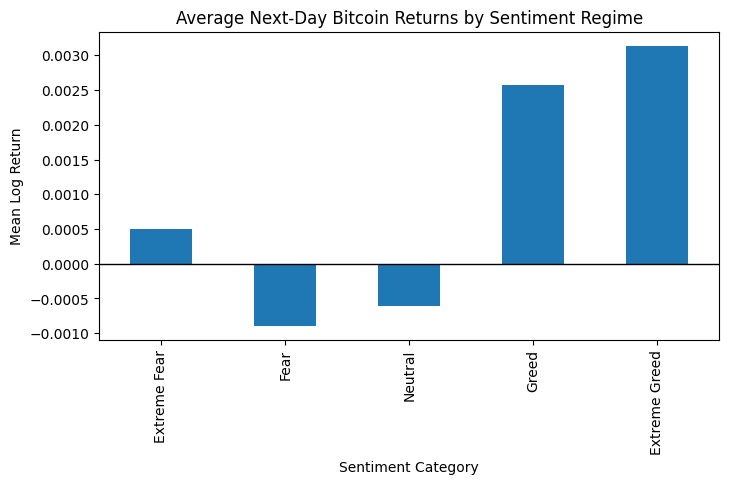

In [22]:
(df.groupby("sentiment_label")["return_t1"]
      .mean()
      .reindex(["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"])
      .plot(kind="bar", figsize=(8,4))
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Average Next-Day Bitcoin Returns by Sentiment Regime")
plt.ylabel("Mean Log Return")
plt.xlabel("Sentiment Category")
plt.show()


In [23]:
# add lagged return 

df["return_t"] = df["return_t1"].shift(1)
df_robust = df.dropna()

X2 = sm.add_constant(df_robust[["sentiment", "return_t"]])
y2 = df_robust["return_t1"]

ols2 = sm.OLS(y2, X2).fit()
nw2 = ols2.get_robustcov_results(cov_type="HAC", maxlags=5)

print(nw2.summary())


                            OLS Regression Results                            
Dep. Variable:              return_t1   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.077
Date:                Mon, 15 Dec 2025   Prob (F-statistic):             0.0463
Time:                        12:43:05   Log-Likelihood:                 5581.4
No. Observations:                2846   AIC:                        -1.116e+04
Df Residuals:                    2843   BIC:                        -1.114e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.002     -1.221      0.2

#### More visualizations!

Returns over time by sentiment regime --> Do returns behave differently over time depending on sentiment?

Persistent differences in return behavior across sentiment regimes

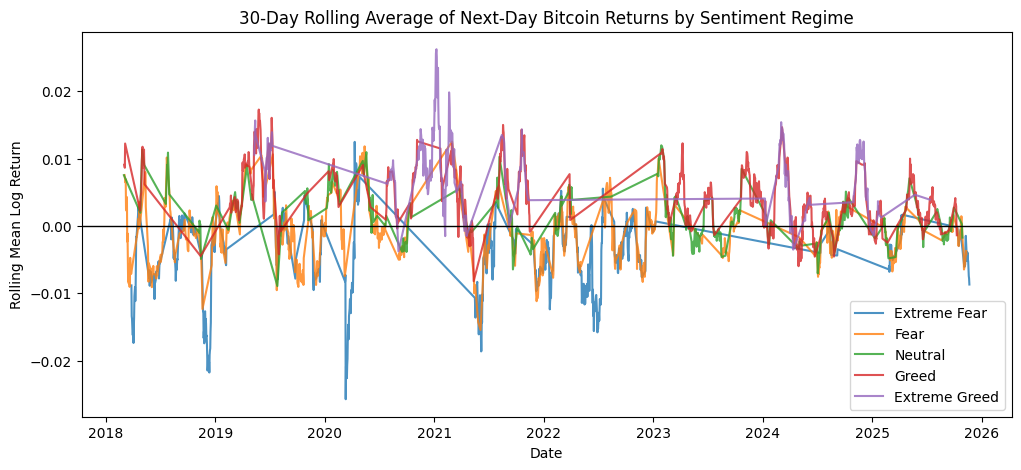

In [24]:
# compute rolling mean 
df["rolling_return"] = df["return_t1"].rolling(30).mean()

plt.figure(figsize=(12,5))

for label in ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]:
    subset = df[df["sentiment_label"] == label]
    plt.plot(subset["Date"], subset["rolling_return"], label=label, alpha=0.8)

plt.axhline(0, color="black", linewidth=1)
plt.title("30-Day Rolling Average of Next-Day Bitcoin Returns by Sentiment Regime")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Log Return")
plt.legend()
plt.show()


Color-coded scatter: sentiment vs next-day returns

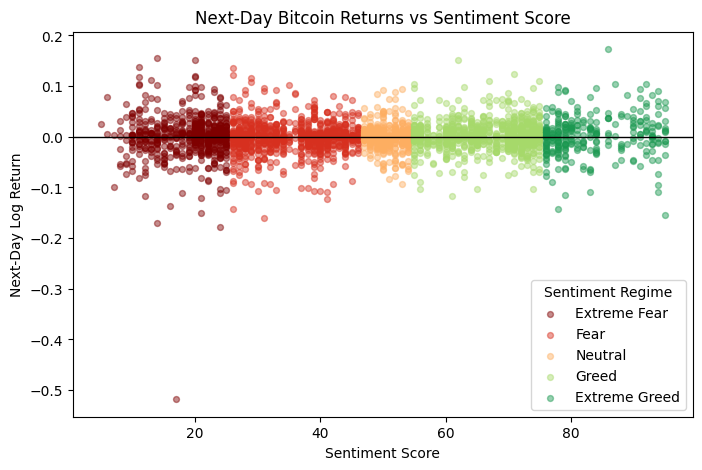

In [25]:
#pretty color code 
sentiment_colors = {
    "Extreme Fear": "#7f0000",   # dark red
    "Fear": "#d7301f",           # red/orange
    "Neutral": "#fdae61",        # neutral orange
    "Greed": "#a6d96a",          # light green
    "Extreme Greed": "#1a9850"   # dark green
}

plt.figure(figsize=(8,5))

for label in ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]:
    subset = df[df["sentiment_label"] == label]
    plt.scatter(
        subset["sentiment"],
        subset["return_t1"],
        label=label,
        color=sentiment_colors[label],
        alpha=0.45,
        s=18
    )

plt.axhline(0, color="black", linewidth=1)
plt.title("Next-Day Bitcoin Returns vs Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Next-Day Log Return")
plt.legend(title="Sentiment Regime")
plt.show()


Direct model comparison

In [26]:
coef_df = pd.DataFrame({
    "Model": ["Baseline OLS", "HAC", "HAC + Lagged Return"],
    "Sentiment Coefficient": [
        ols.params["sentiment"],  
        nw.params[1],           
        nw2.params[1]            
    ]
})


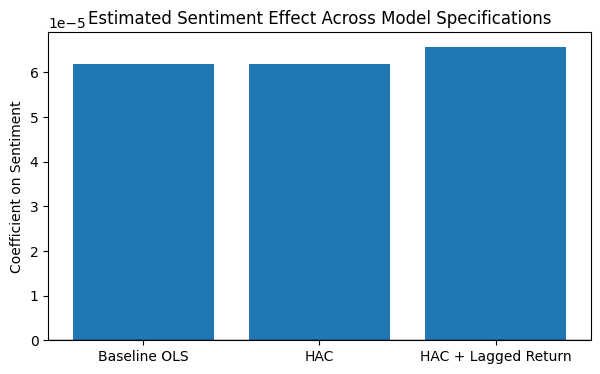

In [27]:
plt.figure(figsize=(7,4))
plt.bar(coef_df["Model"], coef_df["Sentiment Coefficient"])
plt.axhline(0, color="black", linewidth=1)
plt.title("Estimated Sentiment Effect Across Model Specifications")
plt.ylabel("Coefficient on Sentiment")
plt.show()


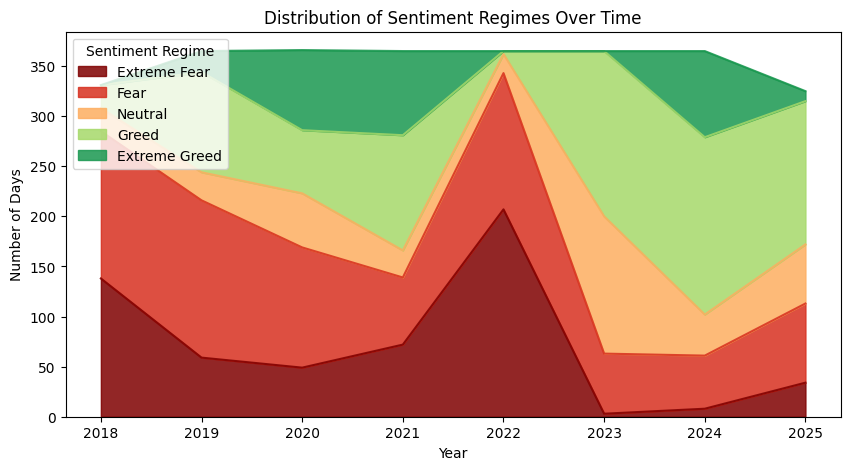

In [28]:
# prepare data
sentiment_year = (
    df.groupby([df["Date"].dt.year, "sentiment_label"])
      .size()
      .unstack()
      .reindex(
          columns=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
      )
)

# plot
sentiment_year.plot(
    kind="area",
    stacked=True,
    figsize=(10,5),
    color=[sentiment_colors[c] for c in sentiment_year.columns],
    alpha=0.85
)

plt.title("Distribution of Sentiment Regimes Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Days")
plt.legend(title="Sentiment Regime", loc="upper left")
plt.show()
